In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

In [10]:
df = pd.read_csv("SeoulBikeDataClean.csv")
df = df[df['functioning_day'] == 'Yes'].copy()
# compute standardized temperature and squared term
df['temp_std'] = (df['temperaturec'] - df['temperaturec'].mean()) / df['temperaturec'].std()
df['temp_std_squared'] = df['temp_std'] ** 2


formula = 'rented_bike_count ~ humiditypct + solar_radiation_mj_m2 + Autumn + Spring + Summer + Winter +' \
' phase0to6 + phase7to9 + phase10to17 + phase18to19 + phase20to24 + is_raining + is_snowing + temperaturec_squared +' \
' is_weekend + is_holiday + is_working_day + temp_rain + temp_snow + lag_1 + lag_24 + rolling_24_mean + rolling_168_mean'

# Fit Poisson regression model
poisson_model = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.Poisson()
).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      rented_bike_count   No. Observations:                 8297
Model:                            GLM   Df Residuals:                     8276
Model Family:                 Poisson   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.8035e+05
Date:                Mon, 12 May 2025   Deviance:                   6.9485e+05
Time:                        17:41:04   Pearson chi2:                 6.95e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.00

In [11]:
# Compute R-squared
null_model = smf.glm(
    formula='rented_bike_count ~ 1',
    data=df,
    family=sm.families.Poisson()
).fit()

pseudo_r2 = 1 - poisson_model.llf / null_model.llf
print(f"\nMcFadden's pseudo R-squared: {pseudo_r2:.4f}")


McFadden's pseudo R-squared: 0.8332


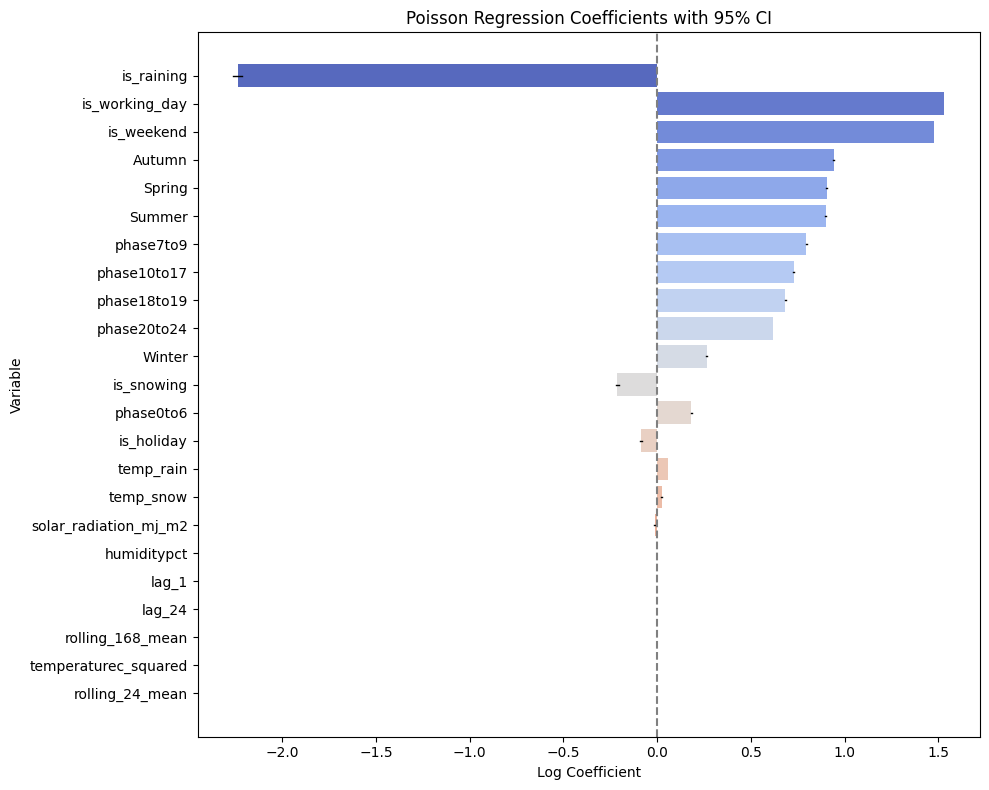

In [12]:
# Extract coefficient summary
coef_df = poisson_model.summary2().tables[1].reset_index()
coef_df.columns = ['variable', 'coef', 'std_err', 'z', 'P>|z|', '[0.025', '0.975]']

# Exclude intercept for better scaling
coef_df = coef_df[coef_df['variable'] != 'Intercept']
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    data=coef_df,
    y='variable', x='coef',
    orient='h',
    palette='coolwarm',
    errorbar=None
)

# Add 95% confidence intervals as lines
for i, row in enumerate(coef_df.itertuples()):
    plt.plot([row._6, row._7], [i, i], color='black', lw=1)

plt.axvline(0, color='gray', linestyle='--')
plt.title("Poisson Regression Coefficients with 95% CI")
plt.xlabel("Log Coefficient")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


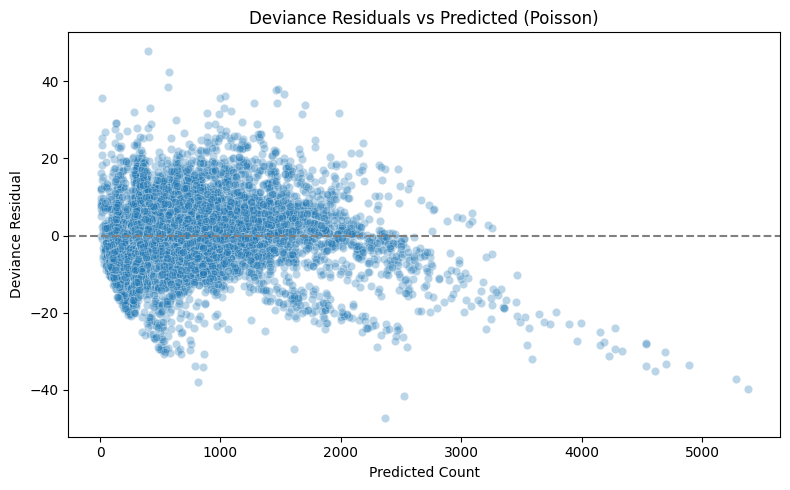

In [13]:
# Compute predicted values and deviance residuals
df['predicted'] = poisson_model.predict()
df['deviance_resid'] = poisson_model.resid_deviance

# Plot deviance residuals vs predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x='predicted', y='deviance_resid', data=df, alpha=0.3)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Deviance Residuals vs Predicted (Poisson)")
plt.xlabel("Predicted Count")
plt.ylabel("Deviance Residual")
plt.tight_layout()
plt.show()


# train–val–test split

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [15]:
# 1. Load cleaned dataset
df = pd.read_csv("SeoulBikeDataClean.csv")

# 2. Parse date
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y", errors="coerce")
df = df.dropna(subset=["date"])

# 3. Sort chronologically (important!)
df = df.sort_values("date")

# 4. Split based on date ranges
train_df = df[df["date"] < "2018-07-01"].copy()
val_df = df[(df["date"] >= "2018-07-01") & (df["date"] < "2018-10-01")].copy()
test_df = df[df["date"] >= "2018-10-01"].copy()

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

# 5. Standardize temperature
mean_temp = train_df["temperaturec"].mean()
std_temp = train_df["temperaturec"].std()
for split_df in [train_df, val_df, test_df]:
    split_df["temp_std"] = (split_df["temperaturec"] - mean_temp) / std_temp
    split_df["temp_std_squared"] = split_df["temp_std"] ** 2

# 6. Poisson regression formula
formula = (
    'rented_bike_count ~ temp_std + temp_std_squared + '
    'is_raining + is_snowing + is_holiday + is_working_day + '
    'C(hour)'
)

# 7. Fit Poisson model
poisson_model = smf.glm(formula=formula, data=train_df, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

Train: (4872, 40), Val: (2112, 40), Test: (1313, 40)
                 Generalized Linear Model Regression Results                  
Dep. Variable:      rented_bike_count   No. Observations:                 4872
Model:                            GLM   Df Residuals:                     4842
Model Family:                 Poisson   Df Model:                           29
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3349e+05
Date:                Mon, 12 May 2025   Deviance:                   4.2971e+05
Time:                        17:41:05   Pearson chi2:                 4.09e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------


Validation Set Metrics: {'RMSE': 755.948121315378, 'MAE': 546.3287850433353, 'R²': -0.35538323960944784}
Test Set Metrics: {'RMSE': 389.099023439321, 'MAE': 293.4120771471071, 'R²': 0.5194400454065795}


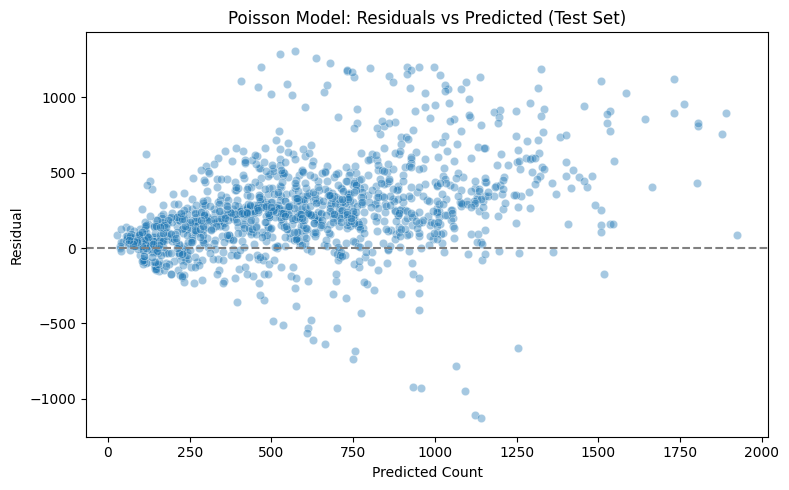

In [16]:
# 8. Predict
val_df["predicted_count"] = poisson_model.predict(val_df)
test_df["predicted_count"] = poisson_model.predict(test_df)

# 9. Evaluate
def evaluate(true, pred):
    return {
        "RMSE": mean_squared_error(true, pred, squared=False),
        "MAE": mean_absolute_error(true, pred),
        "R²": r2_score(true, pred)
    }

val_metrics = evaluate(val_df["rented_bike_count"], val_df["predicted_count"])
test_metrics = evaluate(test_df["rented_bike_count"], test_df["predicted_count"])

print("\nValidation Set Metrics:", val_metrics)
print("Test Set Metrics:", test_metrics)

# 10. Residual plot on test set
test_df["residual"] = test_df["rented_bike_count"] - test_df["predicted_count"]
plt.figure(figsize=(8, 5))
sns.scatterplot(x="predicted_count", y="residual", data=test_df, alpha=0.4)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Poisson Model: Residuals vs Predicted (Test Set)")
plt.xlabel("Predicted Count")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()